<a href="https://colab.research.google.com/github/choderalab/pinot/blob/examples/examples/how_to_make_your_neural_network_somewhat_bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to make your neural network somewhat Bayesian
=================================================
Yuanqing Wang (wangyq@wangyq.net)

# Download and Install

In [1]:
! rm -rf /content/pinot
! git clone https://github.com/choderalab/pinot.git --depth=1
! cd /content/pinot && pip install -q -r requirements.txt && pip install -q .

Cloning into 'pinot'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 255 (delta 21), reused 169 (delta 9), pack-reused 0
Receiving objects: 100% (255/255), 26.72 MiB | 16.67 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
import torch
import numpy as np
import pinot
import math

Using backend: pytorch


# Overview

In this tutorial, we forget about graph space for a minute, and study the inference methods in `pinot` on 1-D input space. 

Under the Bayesian formalism, given sets of (input, measurement) pairs as training data $\mathcal{D} = \{ x^{(i)}, y^{(i)}, i=1,2,3,...,n\}$, the probability distribution of the unknown quantity of the measurement $y^{(n + 1)}$ could be modelled with respect to the posterior distribution of the neural network parameters $\theta$ as:
$$
P(y^{*} | \mathcal{D}, x^*) = \int P(y^{*} | x^*, \mathbf{\theta}) P(\mathbf{\theta} | \mathcal{D}) \operatorname{d} \theta.
$$
This integral, of course, is not tractable. 
If one uses the most likely set of neural network parameters $\theta^\text{MLE} = \underset{\theta}{\arg\max} \, P(\theta | \mathcal{D})$, which is optimized by back-propagation, a standard neural network with Maximum Likelihood Estimate (MLE) is recovered. The aforementioned integration is then approximated using a delta function.

So what's the problem with that? Let's look at some toy data.

# Data

Let's say the true dynamic of our toy data is a `sin` function.

In [3]:
f = lambda x: torch.sin(x)

In real-world problems, however, one would never know such underlying structure.

To mimic the situation where training data is very limited, we use only the $x \in [-3 \pi, -\pi] \cup [\pi, 3\pi]$ as training data.

In [4]:
x_tr = torch.tensor(np.concatenate(
    [
        np.linspace(-3 * math.pi, -math.pi, 50),
        np.linspace(math.pi, 3 * math.pi, 50)
    ]),
    dtype=torch.float32)[:, None]

y_tr = f(x_tr)

This looks like such:

(-30.0, 30.0, -1.0994348287582398, 1.0994348287582398)

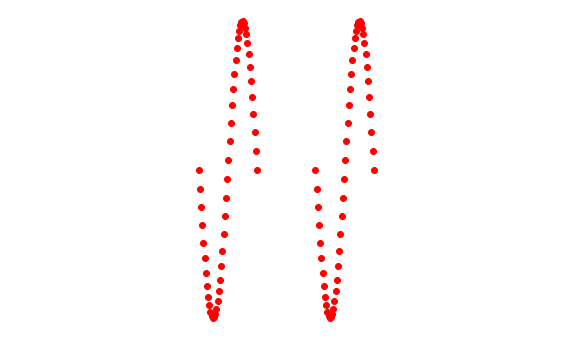

In [40]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x_tr, y_tr, color='r')
plt.xlim(-30, 30)
plt.axis('off')

We then specify the test data to be the rest of $x \in [-7\pi, 7\pi]$

In [5]:
x_te = torch.tensor(np.concatenate(
    [
        np.linspace(-7 * math.pi, -3 * math.pi, 100),
        np.linspace(-math.pi, math.pi, 50),
        np.linspace(3 * math.pi, 7 * math.pi, 100)
    ]),
    dtype=torch.float32)[:, None]

x = torch.tensor(np.linspace(-7 * math.pi, 7 * math.pi, 375),
                 dtype=torch.float32)[:, None]


y_te = f(x_te)
y = f(x)

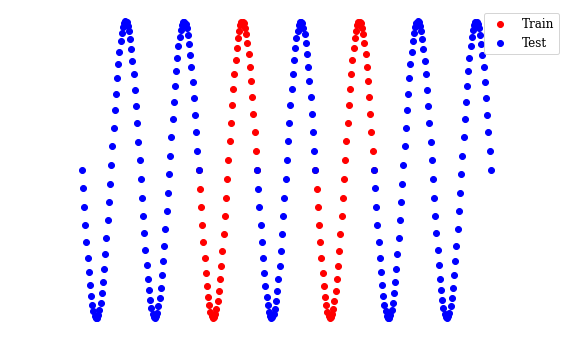

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.rc('font', family='serif', size=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.scatter(x_tr, y_tr, color='r', label='Train')
plt.scatter(x_te, y_te, color='b', label='Test')
plt.xlim(-30, 30)
plt.axis('off')
plt.legend()

# Plotting

Define plotting utility function. This plots 0.95, 0.75, 0.50, and 0.25 confidence intervals on top of mean prediction.

In [22]:
def plot(net):
    from matplotlib import pyplot as plt
    from pinot.samplers import utils
    plt.figure(figsize=(10, 6))
    plt.rc('font', family='serif', size=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)

    if hasattr(optimizer, 'sample_params'):
        y_hat_distribution = pinot.samplers.utils.condition_mixture(net, x, sampler=optimizer, n_samples=1000)

    else:
        y_hat_distribution = net.condition(x)

    nll = pinot.metrics.avg_nll(net, x, y)

    plt.plot(x, y_hat_distribution.mean.detach().numpy(), c='k', linewidth=5)

    low, high = pinot.samplers.utils.confidence_interval(y_hat_distribution, 0.95, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten().detach().numpy(), high.flatten().detach().numpy(), color='k', alpha=0.1)
    
    low, high = pinot.samplers.utils.confidence_interval(y_hat_distribution, 0.75, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten().detach().numpy(), high.flatten().detach().numpy(), color='k', alpha=0.2)

    low, high = pinot.samplers.utils.confidence_interval(y_hat_distribution, 0.50, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten().detach().numpy(), high.flatten().detach().numpy(), color='k', alpha=0.3)

    low, high = pinot.samplers.utils.confidence_interval(y_hat_distribution, 0.25, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten().detach().numpy(), high.flatten().detach().numpy(), color='k', alpha=0.4)

    plt.scatter(x_te, y_te, color='b')
    plt.scatter(x_tr, y_tr, color='r')
    plt.ylim(-2, 2)
    plt.xlim(-30, 30)
    plt.title('NLL=%s' % nll.detach().numpy().round(3))
    plt.axis('off')


# Architecture

Here we use a simple neural network as the representation layer.

In [23]:
net_representation = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 32),
        torch.nn.Tanh())

# Maximum Likelihood Estimate

Let's see how would a vanilla neural network behave on such dataset. Note that we assume heteroschedastic gaussian noise on the output.

In [16]:
net_representation = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 32),
        torch.nn.Tanh())

net = pinot.Net(
    net_representation, 
    
    output_regressor=pinot.regressors.NeuralNetworkRegressor,
    noise_model='normal-heteroschedastic')

In [17]:
# train it!
optimizer = torch.optim.Adam(net.parameters(), 1e-3)
for _ in range(1000):
    def l():
        optimizer.zero_grad()
        loss = net.loss(x_tr, y_tr).sum()
        loss.backward()
        return loss
        
    optimizer.step(l)

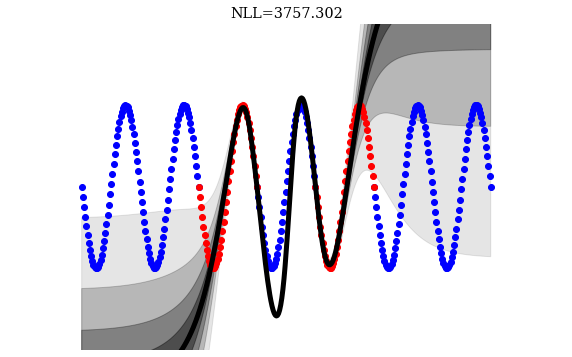

In [23]:
plot(net)

This doesn't look bad at all, does it? It also guessed the period between training data ($x \in [-\pi, \pi]$) pretty well. The only problem is that error bar doesn't mean too much, resulting in a relatively low likelihood.

# Langevin Dynamics

Naturally, one can sample the weight space to make a model Bayesian. Here we use one of the newest model [AdLaLa](https://arxiv.org/pdf/1908.11843.pdf) that partitions the model into Langevin and Adaptive Langevin regions.

In [24]:
net_representation = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 32),
        torch.nn.Tanh())

net = pinot.Net(
    net_representation, 
    output_regressor=pinot.regressors.NeuralNetworkRegressor,
    noise_model='normal-heteroschedastic')

In [25]:
# train it!
optimizer = pinot.AdLaLa(
    params=[
            {'params': net.representation.parameters()},
            {'params': net.output_regressor.parameters()},

    ],
    h=1e-3)

for _ in range(1000):
    def l():
        optimizer.zero_grad()
        loss = net.loss(x_tr, y_tr).sum()
        loss.backward()
        return loss
        
    optimizer.step(l)

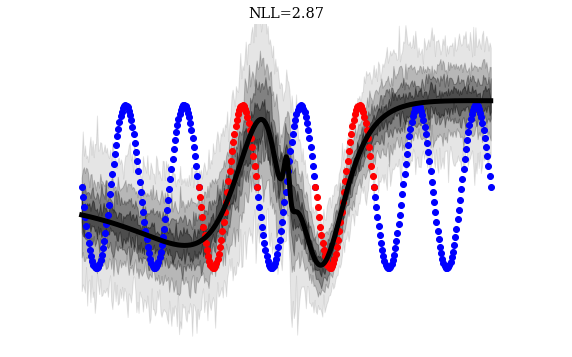

In [26]:
plot(net)

The model prediction looks more regularized, as a result of the Bayesian formalism. Note that this model comes with many hyperparameters that can drastically change the behaviors of the model. See https://arxiv.org/pdf/1908.11843.pdf for details.

# Bayes-by-Backprop

[Bayes-by-backprop](https://arxiv.org/abs/1505.05424) is one of the simplest types of variational inference, where the variational posterior approximating $P(\theta | \mathcal{D})$ is chosen to be a multivariate Gaussian with diagonal covariance matrix. 
\begin{equation}
q(\mathbf{\theta}) = \mathcal{N}(\mathbf{\mu}, \mathbf{\sigma}),
\end{equation}
where the variational parameters $\{ \mathbf{\mu}, \mathbf{\sigma} \}$ have the same dimension as $\mathbf{\theta}$ and are trained by minimizing the Kullback-Leibler (KL) divergence between the variational and true Bayesian posterior:
\begin{equation}
\mathbf{\mu}^{*}, \mathbf{\sigma}^{*} = \underset{\mathbf{\mu}, \mathbf{\sigma}}{\arg\min} \mathcal{D}_\text{KL}[q(\mathbf{\theta} | \mathbf{\mu}, \mathbf{\sigma}) || P(\mathbf{\theta} | \mathcal{D})] = \underset{\mathbf{\mu}, \mathbf{\sigma}}{\arg\min} \mathcal{D}_\text{KL}[q(\mathbf{\theta} | \mathbf{\mu}, \mathbf{\sigma}) || P(\mathbf{\theta})] - \mathbb{E}_{\mathbf{\theta} \sim q(\mathbf{\mu}, \mathbf{\sigma})}[\log P(\mathcal{D} | \mathcal{\theta})],
\end{equation}
which is also termed a \emph{variational free energy}. 
When training is complete, the aforementioned integration can be written as:
\begin{equation}
P(y^{*}|\mathcal{D}, \mathbf{\theta})
\approx \int P(y|\mathbf{\theta}) q(\theta|\mathbf{\mu}, \mathbf{\sigma}),
\end{equation}
which is tractable.

In [84]:
net_representation = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 32),
        torch.nn.Tanh())

net = pinot.Net(
    net_representation, 
    output_regressor=pinot.regressors.NeuralNetworkRegressor,
    noise_model='normal-heteroschedastic')

In [85]:
# train it!
optimizer = pinot.BBB(
    torch.optim.Adam(net.parameters(), 1e-3),
    initializer_std=1e-3,
    kl_loss_scaling=0.01)
for _ in range(1000):
    def l():
        optimizer.zero_grad()
        loss = net.loss(x_tr, y_tr).sum()
        loss.backward()
        return loss
        
    optimizer.step(l)

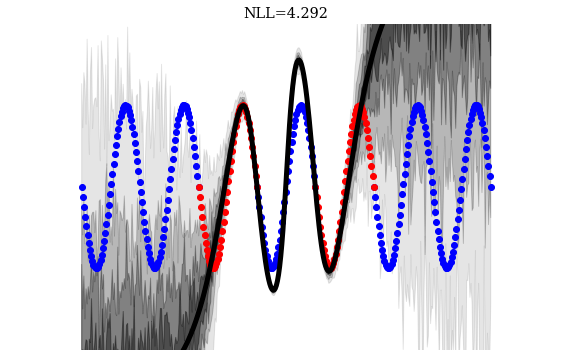

In [86]:
plot(net)

# Deep Kernel Learning with Exact Gaussian Process 

Neural networks could be incorporated seamlessly into Gaussian progress regression if we use the latent embeddings of neural nets [as inputs to a fixed-dimensional kernel](https://arxiv.org/abs/1511.02222). 
Concretely, if we model the real process that maps input to target, $f: x \rightarrow y$, as a Gaussian process,
\begin{equation}
f(x) \sim \mathcal{GP}(\mathbf{0}, K(x, x')),
\end{equation}
therefore the joint distribution of the function values $\mathbf{y*}$ associated with test inputs $\{x^*\}$ could be written as:
\begin{equation}
\begin{bmatrix}
\mathbf{y} \\ \mathbf{y}^* 
\end{bmatrix}
\sim \mathcal{N}\big(
\begin{bmatrix}
K(\mathbf{x}, \mathbf{x}) + \sigma_n^2I &
K(\mathbf{x}, \mathbf{x}^*) \\
K(\mathbf{x}^*, \mathbf{x}) &
K(\mathbf{x},\mathbf{x})
\end{bmatrix}
\big),
\end{equation}
and the predictive distribution becomes:
\begin{equation}
\mathbf{y}^*|\mathcal{D}, \mathbf{x}, \mathbf{x}^* \sim \mathcal{N}(\mathbb{E}[y^*], \operatorname{cov}(y^*)),
\end{equation}
where $\sigma_n$ is the predictive noise and
\begin{align}
\mathbb{E}[\mathbf{y}^*] &= K(\mathbf{x}^*, \mathbf{x})
[K(\mathbf{x}, \mathbf{x}) + \sigma_n^2 I] ^{-1} \mathbf{y};\\
\operatorname{cov}(\mathbf{y}^*) &= K(\mathbf{x}^*, \mathbf{x}^*) - K(\mathbf{x}^*, \mathbf{x})[K(\mathbf{x}, \mathbf{x}) + \sigma_n^2 I]^{-1} K(\mathbf{x}, \mathbf{x}^*).
\end{align}
As such, the parameters associated with the neural net $\theta$ could be viewed as part of the hyperparameter of the kernel and be optimized jointly by maximizing the likelihood of training data.

In [87]:
net_representation = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 32),
        torch.nn.Tanh())

net = pinot.Net(
    net_representation, 
    output_regressor=pinot.regressors.ExactGaussianProcessRegressor,
)

In [88]:
# train it!
optimizer = torch.optim.Adam(net.parameters(), 1e-3)
for _ in range(1000):
    def l():
        optimizer.zero_grad()
        loss = net.loss(x_tr, y_tr).sum()
        loss.backward()
        return loss
        
    optimizer.step(l)

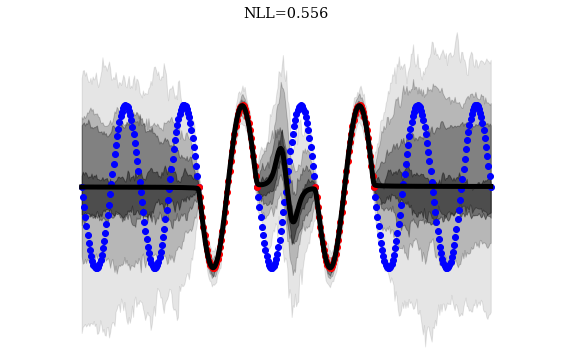

In [96]:
plot(net)

The plot shows that the model is certain where there is data, and conservatively uncertain when away from data.

# Deep Kernel Learning with Variational Gaussian Process

Exact Gaussian Process is not always feasible when you have more than a few thousand data points, since the linear solve step in both training and inference has $\mathcal{O}(n^3)$ complexity, where $n$ is the number of data points in training set. One way to solve this is to use generated (latent input, output) pair as training set ([stochastic variational deep kernel learning](https://arxiv.org/abs/1611.00336)). 

In [97]:
net_representation = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 32),
        torch.nn.Tanh())

net = pinot.Net(
    net_representation, 
    output_regressor=pinot.regressors.VariationalGaussianProcessRegressor,
)

In [98]:
# train it!
optimizer = torch.optim.Adam(net.parameters(), 1e-3)
for _ in range(1000):
    def l():
        optimizer.zero_grad()
        loss = net.loss(x_tr, y_tr).sum()
        loss.backward()
        return loss
        
    optimizer.step(l)

/usr/local/lib/python3.6/dist-packages/pinot/regressors/gaussian_process_regressor.py:324: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  torch.range(0, self.y_tr_sigma_diag.shape[0] - 1)[:, None],
/usr/local/lib/python3.6/dist-packages/pinot/regressors/gaussian_process_regressor.py:325: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  torch.range(0, self.y_tr_sigma_diag.shape[0] - 1)[None, :],


/usr/local/lib/python3.6/dist-packages/pinot/regressors/gaussian_process_regressor.py:324: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  torch.range(0, self.y_tr_sigma_diag.shape[0] - 1)[:, None],
/usr/local/lib/python3.6/dist-packages/pinot/regressors/gaussian_process_regressor.py:325: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  torch.range(0, self.y_tr_sigma_diag.shape[0] - 1)[None, :],


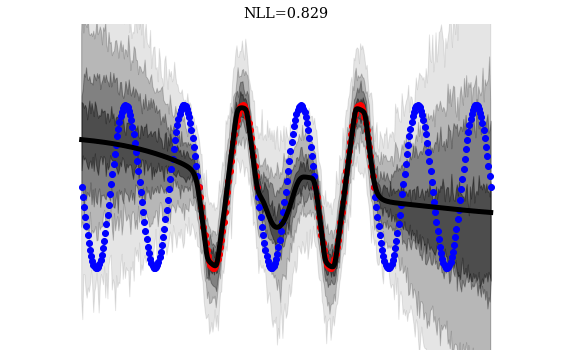

In [99]:
plot(net)

As expected, the performance is a littl bit worse than exact GP. But just a little bit.